# DESI MWS SV ANALYSIS

* Reads the data generated by `example_mainsurvey_analysis.ipynb`

In [36]:
RUN_NAME = 'tutorial_main_survey'

In [37]:
# %load scripts/nbpreamble.py
if not 'RUN_NAME' in locals():
    RUN_NAME = 'unknown'

import sys
import os
import shutil
import glob
import numpy as np
import warnings
import subprocess
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

# SV planning object classes
import apcsv.plan
reload(apcsv.plan)
from apcsv.plan import Tile, Dither

# Helpful function to deal with multiple warnings
def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))

# Print some debug info
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

# Write all the files under this path
ROOT_DIR  = os.getcwd()
WORK_ROOT = os.path.join(ROOT_DIR,'runs',RUN_NAME)
print('Files will be written under {}'.format(WORK_ROOT))

if not os.path.exists(WORK_ROOT):
    os.makedirs(WORK_ROOT)
    
print()
print('Files under this directory:')
!tree --noreport -C --filelimit 10 -I '*.py*' $ROOT_DIR

print()
print('Files under the run directory:')
!date
!tree --noreport -C -D --filelimit 10 $WORK_ROOT/run

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

# Set up paths
rundir   = os.path.join(WORK_ROOT,'run')
datadir  = os.path.join(rundir,'data')
outdir   = os.path.join(rundir,'output')

for _dir in [rundir,datadir,outdir]:
    os.makedirs(_dir,exist_ok=True)  
    
resource_paths = {
     "skies"  : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
     "gfas"   : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

resource_names = {
    "skies"   : "dr7.1-0.22.0.fits", 
    "gfas"    : "dr7.1.fits",
}

mtl_path           = os.path.join(datadir, 'mtl.fits')
std_path           = os.path.join(datadir, 'std.fits')
local_targets_path = os.path.join(datadir, 'sv_targets.fits')

sky_path     = os.path.join(resource_paths["skies"], 
                          "skies-{}".format(resource_names["skies"]))
gfa_path     = os.path.join(resource_paths["gfas"], 
                          "gfas-{}".format(resource_names["gfas"]))



Thu Mar 14 21:31:22 PDT 2019
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.28.0.dev2909      
desimodel       0.9.10.dev477       
fiberassign     0.11.1.dev2271

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan
Files will be written under /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey

Files under this directory:
/global/u1/a/apcooper/projects/mws_svplan [23 entries exceeds filelimit, not opening dir]

Files under the run directory:
Thu Mar 14 21:31:22 PDT 2019
/global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run
├── [Mar 14 21:03]  data
│   ├── [Mar 14 21:03]  mtl.fits
│   ├── [Mar 14 21:03]  std.fits
│   └── [Mar 14 21:03]  sv_targets.fits
└── [Mar 14 21:29]  output
    ├── [Mar 14 21:27]  fiberassign_000000.fits
    └── [Mar 14 21:29]  tile-000000.fits

Usef

Patch in our own targetmask (for analysis just need the mask, there's no need to patch the target cuts).

In [38]:
import apcsv.patch
reload(apcsv.patch)
from apcsv.patch import patch_desitarget_bits

# Restores targetmask to default
reload(desitarget)
reload(desitarget.targetmask)

# Patch with our definitions
new_yaml = os.path.join(ROOT_DIR,'targetmasks/targetmask.yaml')
desi_mask, bgs_mask, mws_mask, obsmask, obsconditions = patch_desitarget_bits(desitarget,
                                                                              new_yaml)

In [39]:
# Useful functions; warnings not important
import apcsv.util
reload(apcsv.util)
import apcsv.fiberqa
reload(apcsv.fiberqa);

BLUE FAINT not defined in current targetmask
RED FAINT not defined in current targetmask
BLUE FAINT & WD not defined in current targetmask
RED FAINT & WD not defined in current targetmask


In [40]:
# Read the MTL
print('MTL:',mtl_path)
mtl = fitsio.read(mtl_path)

MTL: /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/data/mtl.fits


In [41]:
# Read the outputs of the fiberassign python script (post-processed/value-added 
# versions of raw output from fiberassign_exec). There are 3 extensions.
print('Fiber tile dir:',outdir)
fib = apcsv.fiberqa.load_fiber_data(outdir,'FIBERASSIGN')
pot = apcsv.fiberqa.load_fiber_data(outdir,'POTENTIAL_ASSIGNMENTS')
tgt = apcsv.fiberqa.load_fiber_data(outdir,'TARGETS')

Fiber tile dir: /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/output
Have 1 tiles
Have 1 tiles
Have 1 tiles


Analysis of a single tile.

In [42]:
t = Table(fib[0])
t[0:2]

FIBER,LOCATION,NUMTARGET,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,APFLUX_G [2],APFLUX_R [2],APFLUX_Z [2],APFLUX_IVAR_G [2],APFLUX_IVAR_R [2],APFLUX_IVAR_Z [2]
int32,int32,int16,int64,int64,int64,int64,float64,float64,float32,float32,str8,int32,float32,float32,float32,str3,int16,int32,int32,float64,int32,int32,int32,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,bytes1,int64,int64,int64,float32,float32,float32,float32,float32,float32
0,95,120,30788173948781703,1152921504606846976,131586,0,0.0104150800259,19.4577820959,-2.40738,-173.775,0001p195,0,269.206,173.832,5400.0,TGT,0,95,2100,0.917009046328,4,0,7000,440686,1159,COMP,3.739e+10,9.09788e+10,12306.7 .. 23660.0,0.0455249,12.1513,20.4199,30.6635,17.6381,10.3328,3.14553,-517.248,43.79,30.9936,4.63766,1.7757,0.345098,0.000606429,1.55424e-05,0.873923,0.91322,0.95049,0.992315,0.995273,0.99899,0.999619,1,2,4,0.0224134,0.0872177,0.0112438,0.0357258,0.0344495,0.0354566,0.92297,0.921493,0.921319,0,0,0,498.233,283.601,79.1046,346.149,204.661,42.2888,0.332503,7042.81,5.52413,36.9151,-0.623613,2094.64,0.328386,1527.52,3.17318,1058.72,-0.163288,9217.8,-0.292229,14414.9,1.33256,2.23934,3.36269,1.33298,2.24199,3.36324,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,False,S,2100,1,19711,-4.42377e+19 .. -1.76951e+20,-7.07804e+20 .. -2.83121e+21,-1.15967e+25 .. -4.63866e+25,-1.85547e+26 .. -7.42186e+26,-2.96874e+27 .. -1.1875e+28,-4.74999e+28 .. -1.9e+29
1,62,0,30788173948782615,2305843009213693952,0,1792,0.21851910242,19.5190568764,-50.4559,-158.614,0001p195,0,252.354,166.481,5400.0,TGT,0,62,1500,0.450382646469,7,0,7000,440686,2071,PSF,5.76242e+14,3.01001e+15,1.0823e+06 .. 0.0,0.0443781,66.8983,100.346,116.479,30.7297,17.9592,-14.2331,76.3762,61.9083,20.5159,44.1283,3.66383,0.654303,0.000950412,2.01406e-05,0.876895,0.915311,0.951707,0.992507,0.995392,0.999015,0.999628,1,1,6,0.0,0.0,0.0,0.00298229,0.00340994,0.0124291,0.999472,0.999596,0.999576,0,0,0,485.537,142.268,91.8299,335.057,89.1286,51.3107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.9264

In [43]:
# Report numbers for each raw MWS bit
print('{:10s} {:10s}'.format('MWS_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['MWS_TARGET'],return_counts=True)):
    print('{:<10d} {:<10d} {:s}'.format(a,b,' & '.join(mws_mask.names(a))))

MWS_TARGET NTARGETS  
0          4263       
2          33         MWS_WD
4          11         MWS_NEARBY
6          1          MWS_WD & MWS_NEARBY
49         81         MWS_BROAD & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
1792       435        MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1794       7          MWS_WD & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1798       4          MWS_WD & MWS_NEARBY & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
14336      165        MWS_MAIN_RED & MWS_MAIN_RED_NORTH & MWS_MAIN_RED_SOUTH


In [44]:
# Report numbers for each raw DESI bit, for MWS targets
is_mws = t['MWS_TARGET'] > 0 
is_bgs = t['BGS_TARGET'] > 0 

print('MWS targets')
print('{:20s} {:10s}'.format('DESI_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['DESI_TARGET'][is_mws],return_counts=True)):
    print('{:<20d} {:<10d} {:s}'.format(a,b,' & '.join(desi_mask.names(a))))
print()

print('BGS targets')
print('{:20s} {:10s}'.format('DESI_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['DESI_TARGET'][is_bgs],return_counts=True)):
    print('{:<20d} {:<10d} {:s}'.format(a,b,' & '.join(desi_mask.names(a))))
print()

print('Other targets')
print('{:20s} {:10s}'.format('DESI_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['DESI_TARGET'][~(is_mws | is_bgs)],return_counts=True)):
    print('{:<20d} {:<10d} {:s}'.format(a,b,' & '.join(desi_mask.names(a))))

MWS targets
DESI_TARGET          NTARGETS  
2305843009213693952  623        MWS_ANY
2305843017803628544  32         STD_FAINT & MWS_ANY
2305843026393563136  43         STD_WD & MWS_ANY
2305843052163366912  22         STD_FAINT & STD_BRIGHT & MWS_ANY
3458764513820540928  15         BGS_ANY & MWS_ANY
3458764531000410112  2          STD_WD & BGS_ANY & MWS_ANY

BGS targets
DESI_TARGET          NTARGETS  
1152921504606846976  3855       BGS_ANY
3458764513820540928  15         BGS_ANY & MWS_ANY
3458764531000410112  2          STD_WD & BGS_ANY & MWS_ANY

Other targets
DESI_TARGET          NTARGETS  
4294967296           400        SKY
34359738368          4          STD_BRIGHT
68719476736          4          BAD_SKY


In [45]:
# Report on targets classified as both MWS and non-MWS
reload(apcsv.fiberqa)
apcsv.fiberqa.report_survey_overlaps(t)

114 fibers with both MWS and non-MWS target bits:
 BGS_ANY                          15 BROAD (RED REJECT) | BLUE | RED
 STD_FAINT                        32 BLUE
 STD_FAINT & STD_BRIGHT           22 BLUE
 STD_WD                           43 WD | WD & NEARBY | BLUE & WD
 STD_WD & BGS_ANY                  2 WD


In [46]:
# Report numbers for each priority
print('{:10s} {:10s}'.format('PRIORITY','NTARGETS'))
for a,b in reversed(list(zip(*np.unique(t['PRIORITY'],return_counts=True)))):
    print('{:<10d} {:<10d}'.format(a,b))

PRIORITY   NTARGETS  
2998       45        
2100       2948      
2000       922       
1600       11        
1500       586       
1400       80        
0          408       


WARNING         COUNT
RuntimeWarning  8
WARNING         COUNT
RuntimeWarning  5


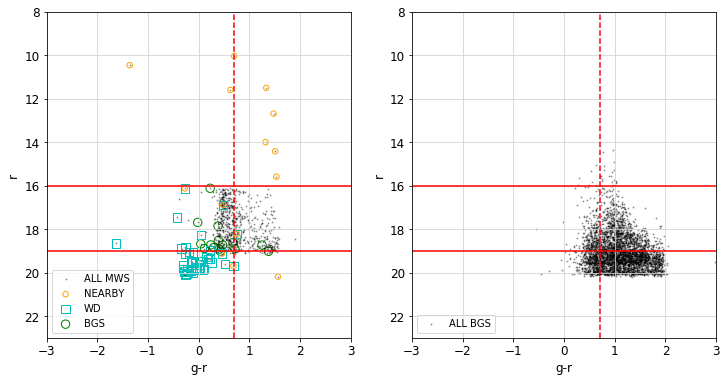

In [55]:
# Colour-magnitude of observed targets
pl.figure(figsize=(12,6))

ax = pl.subplot(121)
with warnings.catch_warnings(record=True) as W:
    #warnings.filterwarnings("ignore",category=RuntimeWarning)
    g = -2.5*np.log10(t['FLUX_G'])+22.5
    r = -2.5*np.log10(t['FLUX_R'])+22.5
    
    is_mws = t['MWS_TARGET'] != 0
    pl.scatter((g-r)[is_mws],r[is_mws],s=1,alpha=0.3,c='k',label='ALL MWS')
    
    is_nearby = t['MWS_TARGET'] & mws_mask['MWS_NEARBY'] != 0 
    pl.scatter((g-r)[is_nearby],r[is_nearby], s=30, facecolor='None',edgecolor='orange',label='NEARBY')

    is_wd = t['MWS_TARGET'] & mws_mask['MWS_WD'] != 0 
    pl.scatter((g-r)[is_wd],r[is_wd], s=70, facecolor='None',edgecolor='c',marker='s',label='WD')
    
    is_bgs =  t['BGS_TARGET'] != 0 
    pl.scatter((g-r)[is_bgs & is_mws],r[is_bgs & is_mws], s=70, facecolor='None',edgecolor='g',marker='o',zorder=-10,label='BGS')
warning_summary(W)

pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)
pl.xlim(-3,3)
pl.legend(loc='lower left')

ax = pl.subplot(122)
with warnings.catch_warnings(record=True) as W:
    #warnings.filterwarnings("ignore",category=RuntimeWarning)
    g = -2.5*np.log10(t['FLUX_G'])+22.5
    r = -2.5*np.log10(t['FLUX_R'])+22.5
    
    is_bgs = t['BGS_TARGET'] != 0
    pl.scatter((g-r)[is_bgs],r[is_bgs],s=1,alpha=0.3,c='k',label='ALL BGS')
warning_summary(W)

pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)
pl.xlim(-3,3)
pl.legend(loc='lower left')

In [56]:
# Wrap RA across 360 deg
def wrap(angle,offset=-60):
    return np.fmod(angle - offset + 360, 360) + offset
wrap_ra     = wrap(t['TARGET_RA'])
wrap_ra_mtl = wrap(mtl['RA'])

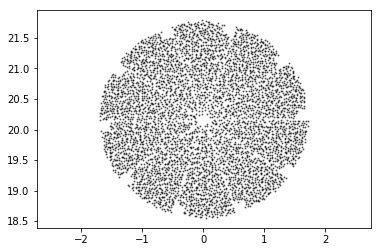

In [57]:
# Sky plot -- all fibers
pl.scatter(wrap_ra,t['TARGET_DEC'],c='k',s=1,alpha=0.5)
pl.axis('equal');

Fractions of target pool observed:

In [92]:
print('{:10s} {:10s} {:10s} {:10s} {:9s}'.format('','N_MTL','N_AVAIL','N_OBS','FRAC_OBS'))
for _ in ['MWS_ANY','BGS_ANY']:
    bitmask = desi_mask.mask(_)
    
    in_mtl    = mtl['DESI_TARGET'] == bitmask
    total_mtl = np.sum(in_mtl)
    
    avail_ids   = np.sort(pot[0]['TARGETID'])
    is_avail    = np.in1d(mtl['TARGETID'][in_mtl],avail_ids, assume_unique=True)
    total_avail = np.sum(is_avail)
    
    total_obs = np.sum(t['DESI_TARGET'] == bitmask)
    print("{:10s} {:<10d} {:<10d} {:<10d} {:<6.3f}".format(_,
                                                           total_mtl,
                                                           total_avail,
                                                           total_obs,
                                                           float(total_obs)/total_avail))

           N_MTL      N_AVAIL    N_OBS      FRAC_OBS 
MWS_ANY    214831     8833       623        0.071 
BGS_ANY    222027     9095       3855       0.424 


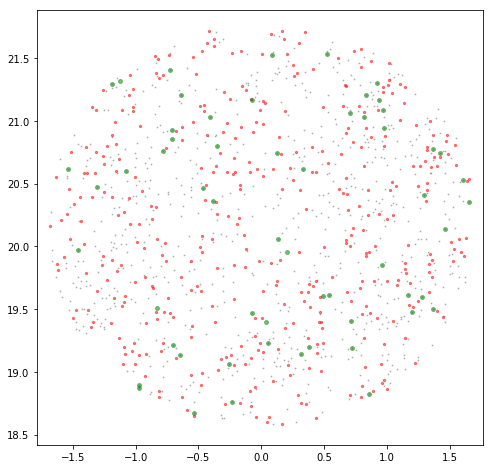

In [91]:
# Sky plot -- MWS SV, skys, stds

pl.figure(figsize=(8,8))

is_mws = t['MWS_TARGET'] > 0
is_sky = t['DESI_TARGET'] & desi_mask.mask('SKY') != 0 
is_std = (t['DESI_TARGET'] & desi_mask.mask('STD_FAINT')) | (t['DESI_TARGET'] & desi_mask.mask('STD_BRIGHT')) != 0

_ = is_mws
pl.scatter(wrap_ra[_],t['TARGET_DEC'][_],c='k',s=1,alpha=0.2)
pl.axis('equal');

_ = is_sky
pl.scatter(wrap_ra[_],t['TARGET_DEC'][_],c='r',s=5,alpha=0.5)
pl.axis('equal');

_ = is_std
pl.scatter(wrap_ra[_],t['TARGET_DEC'][_],c='g',s=15,alpha=0.5)
pl.axis('equal');